In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import shap
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from sklearn.pipeline import make_pipeline
from scipy.stats import shapiro
from scipy.stats import norm as normal_dist
import scipy.stats as stats



Removed 18 highly correlated features: ['$\\ v_{\\mathrm{H}}$', '$\\ d_{\\mathrm{O-H}}$', '$\\ I^{\\mathrm{DW}}_{p, \\mathrm{M}}$', '$\\epsilon ^{\\mathrm{DW}}_{p, \\mathrm{M}}$', '$\\ W^{\\mathrm{DW}}_{p, \\mathrm{M}}$', '$\\ I^{\\mathrm{tot}}_{p, \\mathrm{M}}$', '$\\epsilon ^{\\mathrm{tot}}_{p, \\mathrm{M}}$', '$\\ W^{\\mathrm{tot}}_{p, \\mathrm{M}}$', '$\\ q_{\\mathrm{M,max}}$', '$\\ q_{\\mathrm{M,red}}$', '$\\ d_{\\mathrm{M-H, red}}$', '$\\mu_{\\mathrm{M, max}}$', '$\\mu_{\\mathrm{M, tot}}$', '$\\ I^{\\mathrm{UP}}_{d, \\mathrm{M}}$', '$\\ I^{\\mathrm{DW}}_{d, \\mathrm{M}}$', '$\\ I^{\\mathrm{tot}}_{d, \\mathrm{M}}$', '$\\epsilon^{\\mathrm{tot}}_{d, \\mathrm{M}}$', '$\\ W^{\\mathrm{tot}}_{d, \\mathrm{M}}$']

Saved Pearson correlations to Pearson_target_features_H2O.txt


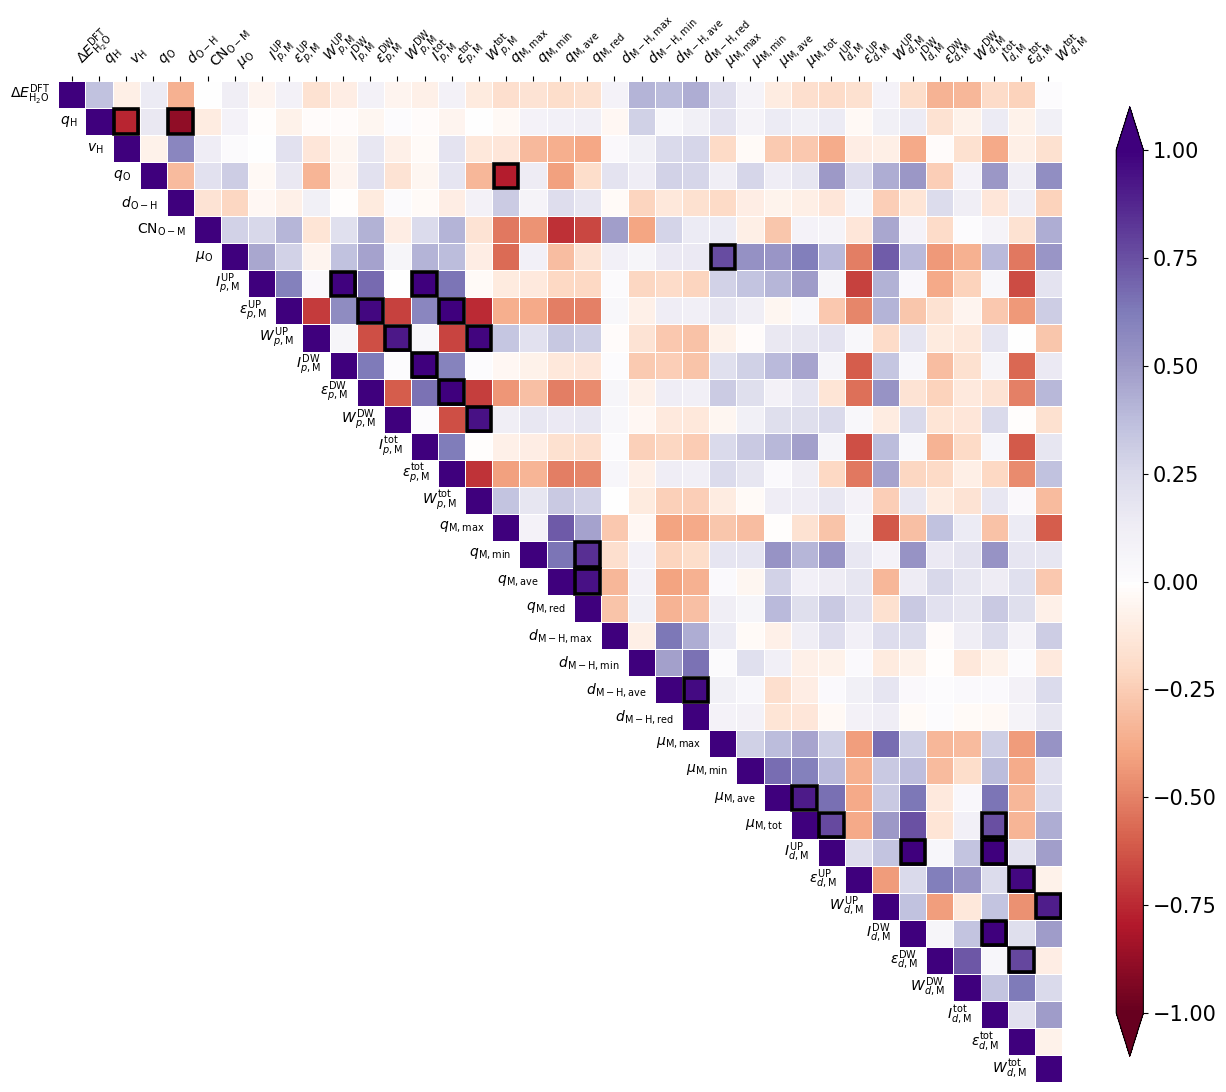

In [2]:
# 1. Load the dataset
file_path = "3d_H2O"
data = pd.read_csv(file_path, delimiter="\t")
#print(data.iloc[0:6, :])
#print(" ")

# 2. Extract features and target variable
materials = data.iloc[:, 0]  # First column (materials name list)
X = data.iloc[:, 2:]  # Features
y = data.iloc[:, 1]   # Target (H_Energy)

# Combine y and X for correlation analysis
df = pd.concat([y, X], axis=1)

# Compute correlation matrix
corr_matrix = df.corr()

# Set correlation threshold
correlation_threshold = 0.75
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
X_filtered = X.drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated features: {to_drop}\n")

# ---- Compute Pearson correlations between target (y) and each feature ----
pearson_target = df.corr().iloc[0, 1:]   # row 0 = target, skip the target itself
# ---- Save to file ----
output_file = "Pearson_target_features_H2O.txt"
with open(output_file, "w") as f:
    f.write("Feature\tPearsonCorrelation_with_Target\n")
    for feature, corr_value in pearson_target.items():
        f.write(f"{feature}\t{corr_value:.6f}\n")
print(f"Saved Pearson correlations to {output_file}")


# Create a mask for upper triangle (to avoid duplicate marking)
mask = np.triu(np.ones(corr_matrix.shape), k=1)
strong_corr = (corr_matrix.abs() > correlation_threshold) & (corr_matrix != 1.0)

# Extract feature pairs
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   for i in range(len(corr_matrix.index)) 
                   for j in range(len(corr_matrix.columns)) 
                   if strong_corr.iloc[i, j]]

#print("Highly correlated feature pairs:")
#for f1, f2, value in high_corr_pairs:
#    print(f"{f1} ↔ {f2}: {value:.2f}")

# Create mask for the lower triangle (including diagonal)
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

################################################################
# Customized colorbar
# Get the base colormaps
cmap_1 = plt.colormaps.get_cmap("Purples")
cmap_2 = plt.colormaps.get_cmap("RdGy")
# Sample halves:
n = 256
colors_1 = cmap_1(np.linspace(0.0, 1.0, n//2))
colors_2 = cmap_2(np.linspace(0.0, 0.5, n//2))
# Stack them together
colors_1_2 = np.vstack((colors_2, colors_1))
# Build new colormap
cmap_1_2 = LinearSegmentedColormap.from_list("PrBu", colors_1_2)
################################################################

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 13))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=False, fmt=".2f", cmap=cmap_1_2,
                       linewidths=0.5, vmin=-1, vmax=1, ax=ax, cbar=False)
# Manually add colorbar with extend
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_1_2, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend="both", fraction=0.025, aspect=35)  # [extend] = 'neither','min','max','both'
cbar.ax.tick_params(labelsize=15)

# Highlight values exceeding threshold
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if i < j:
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > correlation_threshold and corr_value != 1.0:
                rect = Rectangle((j+0.05, i+0.05), 0.9, 0.9, 
                                 fill=False, edgecolor='black', lw=2.6)
                ax.add_patch(rect)

# Get color bar axis
#cbar = heatmap.collections[0].colorbar
cbar_ax = cbar.ax  # The color bar axis

# Determine the range of the color bar
cbar_min, cbar_max = cbar.vmin, cbar.vmax
cbar_range = cbar_max - cbar_min

# Convert threshold values to color bar positions
lower_y = (correlation_threshold - cbar_min) / cbar_range  # For positive threshold
upper_y = (1 - cbar_min) / cbar_range  # Upper limit (1)
neg_lower_y = (cbar_min - (-correlation_threshold)) / cbar_range  # For negative threshold
neg_upper_y = (cbar_min - (-1)) / cbar_range  # Lower limit (-1)

# Draw black boxes on the color bar
bar_x = 0.02     # Small left offset
bar_width = 0.93 # Slightly less than full width

#cbar_ax.add_patch(Rectangle((bar_x, lower_y - (1 - correlation_threshold) / 2), bar_width,
#                            (upper_y - lower_y) * 2, fill=False, edgecolor='red', lw=2.2))
#cbar_ax.add_patch(Rectangle((bar_x, neg_upper_y - correlation_threshold), bar_width, 
#                            (neg_lower_y - neg_upper_y)*2, fill=False, edgecolor='red', lw=2.2))
                
# Move y-axis (left) labels close to diagonal and remove the left spine and ticks
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")  # Optional: if you have a y-axis label
#ax.tick_params(axis='y', which='both', right=True, left=False, labelrotation=90)
#ax.spines['left'].set_visible(False)
# Hide default y-axis tick labels
ax.set_yticks([])
# Get feature names
labels = corr_matrix.columns.tolist()
# Add custom y-axis labels along diagonal, horizontally
for i, label in enumerate(labels):
    ax.text(i - 0.3, i + 0.5, label, ha='right', va='center',
            fontsize=10, fontweight='normal', color='black', clip_on=False)


# Move x-axis labels to top, rotate them, and remove the bottom spine
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")  # Optional: if you have an x-axis label
plt.xticks(rotation=45, ha='left')  # Rotate labels for better fit
ax.tick_params(axis='x', which='both', top=True, bottom=False)
ax.spines['bottom'].set_visible(False)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)
    
# Title and show
# plt.title("Feature Correlation Heatmap with Highlighted Strong Correlations")
plt.savefig("Feature Correlation Heatmap_H2O.svg", dpi=600, bbox_inches='tight')
plt.show()

In [3]:
# 3. Split into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=48)

# 3.1 Standardize the Features
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform training data
X_test_scaled = scaler.transform(X_test)        # Transform test data


In [4]:
# 4. Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=100,
                             n_jobs=12,
                             eval_metric='rmse'
                            )
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=12
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [50, 100, ...], 'reg_alpha': [0, 0.1, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",12
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time fo

In [5]:
# Use the best model
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Save model
joblib.dump(best_model, "best_xgb_model_H2O.pkl")

# Repeated K-Fold Cross-Validation (10 repeats of 5-fold CV)
pipeline = make_pipeline(StandardScaler(), best_model)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=100)
cv_scores = cross_val_score(pipeline, X_filtered, y, cv=rkf, scoring='r2')

# Calculate statistics
mean_r2 = np.mean(cv_scores)
std_r2 = np.std(cv_scores)
sem_r2 = stats.sem(cv_scores)
conf_int = stats.t.interval(0.95, len(cv_scores)-1, loc=mean_r2, scale=sem_r2)

# Display results
print(f"\nRepeated K-Fold Cross-Validation Results:")
print(f"Mean R²: {mean_r2:.4f}")
print(f"Std Dev: {std_r2:.4f}")
print(f"95% Confidence Interval for R²: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0}

Repeated K-Fold Cross-Validation Results:
Mean R²: 0.8180
Std Dev: 0.0460
95% Confidence Interval for R²: [0.8048, 0.8312]


Train Data: MAE: 0.1347, RMSE: 0.1805, R²: 0.9875
Test Data: MAE: 0.3923, RMSE: 0.5471, R²: 0.8908


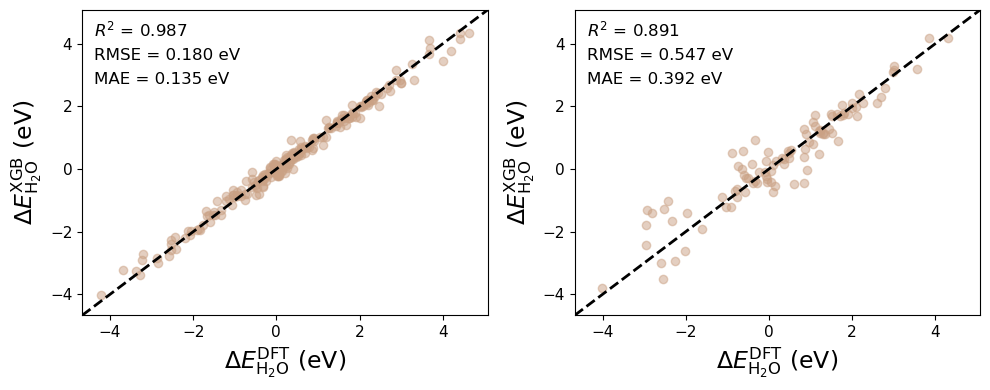

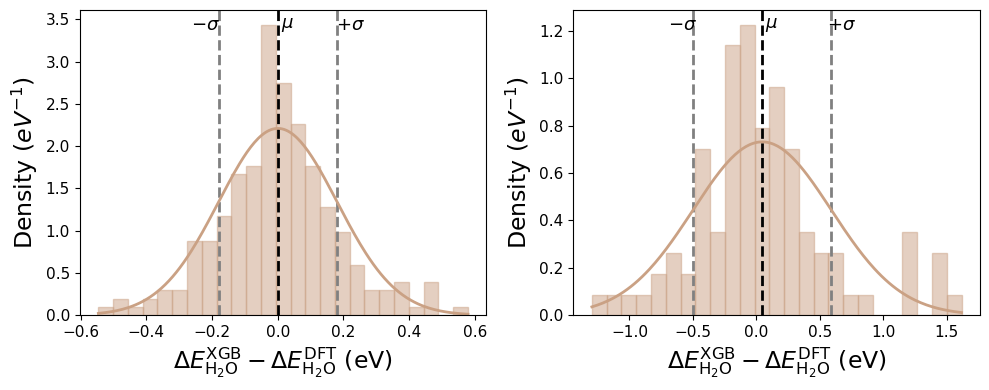

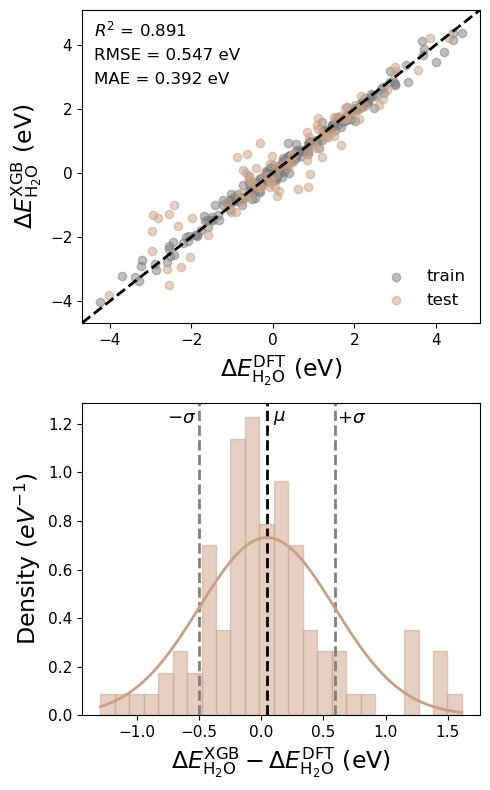

Shapiro-Wilk Train: Statistics=0.986, p=0.027
Shapiro-Wilk Test: Statistics=0.949, p=0.001


In [6]:
# 5. Model Evaluation
y_pred_test = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

print(f"Train Data: MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test Data: MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


# 5.1 Save Predictions to File
abs_errors = np.abs(y_pred_test - y_test)
results_df = pd.DataFrame({
    'Material': materials.iloc[X_test.index].values,
    'y_true': y_test.values,
    'y_pred': y_pred_test,
    'error': y_pred_test - y_test
})

results_df['abs_error'] = abs_errors
results_df_sorted = results_df.sort_values(by='abs_error', ascending=False)
results_df_sorted = results_df_sorted.drop(columns='abs_error')
results_df_sorted.to_csv("y_pred_host_3d_H2O.txt", sep="\t", index=False, float_format="%.6f")


# 5.2 Plot y_test vs. y_pred with Performance Metrics
plt.figure(figsize=(10, 4))

# Compute global min/max
min_val = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
max_val = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())
margin = 0.05 * (max_val - min_val)
min_val -= margin
max_val += margin

# Train Data Plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color="#CAA184", edgecolors="#CAA184", marker='o')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)  # Perfect fit line
plt.xlabel(r"$ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.text(
    0.03, 1-0.03,
    f"$\\it{{R}}^2$ = {r2_train:.3f}\nRMSE = {rmse_train:.3f} eV\nMAE = {mae_train:.3f} eV",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    linespacing=1.75
)
#plt.title(f"Train Data: MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
plt.grid(False)

# Test Data Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color="#CAA184", edgecolors="#CAA184", marker='o')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)  # Perfect fit line
plt.xlabel(r"$ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.text(
    0.03, 1-0.03,
    f"$\\it{{R}}^2$ = {r2_test:.3f}\nRMSE = {rmse_test:.3f} eV\nMAE = {mae_test:.3f} eV",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    linespacing=1.75
)
#plt.title(f"Test Data: MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")
plt.grid(False)

plt.tight_layout()
#plt.savefig("y_true_vs_y_pred_H2O.svg", dpi=600, bbox_inches='tight')
#plt.show()



# 5.3 Plot Deviation Distribution with Standard Deviation Lines
plt.figure(figsize=(10, 4))

# Train Data Plot
plt.subplot(1, 2, 1)
deviation_train = y_pred_train - y_train
mean_dev_train = np.mean(deviation_train)
std_dev_train = np.std(deviation_train)

plt.hist(deviation_train, bins=25, color="#CAA184", alpha=0.5, edgecolor="#CAA184", density=True)
plt.axvline(mean_dev_train, color='black', linestyle='dashed', linewidth=2, label="μ")
plt.axvline(mean_dev_train + std_dev_train, color='grey', linestyle='dashed', linewidth=2, label="+σ")
plt.axvline(mean_dev_train - std_dev_train, color='grey', linestyle='dashed', linewidth=2, label="-σ")
plt.text(mean_dev_train + 0.03, plt.ylim()[1]*0.98, r"$\it{\mu}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_train + std_dev_train + 0.04, plt.ylim()[1]*0.98, r"$+\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_train - std_dev_train - 0.04, plt.ylim()[1]*0.98, r"$-\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.xlabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}} - ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel("Density ($eV^{-1}$)", fontsize=17)
# Plot Normal distibution
x_vals_train = np.linspace(deviation_train.min(), deviation_train.max(), 200)
plt.plot(x_vals_train, normal_dist.pdf(x_vals_train, mean_dev_train, std_dev_train), '-', color="#CAA184", 
         linewidth=2, label='Normal Fit')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.title("Deviation Distribution with Standard Deviation")
#plt.legend()
plt.grid(False)

# Test Data Plot
plt.subplot(1, 2, 2)
deviation_test = y_pred_test - y_test
mean_dev_test = np.mean(deviation_test)
std_dev_test = np.std(deviation_test)

plt.hist(deviation_test, bins=25, color="#CAA184", alpha=0.5, edgecolor="#CAA184", density=True)
plt.axvline(mean_dev_test, color='black', linestyle='dashed', linewidth=2, label="μ")
plt.axvline(mean_dev_test + std_dev_test, color='grey', linestyle='dashed', linewidth=2, label="+σ")
plt.axvline(mean_dev_test - std_dev_test, color='grey', linestyle='dashed', linewidth=2, label="-σ")
plt.text(mean_dev_test + 0.07, plt.ylim()[1]*0.98, r"$\it{\mu}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_test + std_dev_test + 0.08, plt.ylim()[1]*0.98, r"$+\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_test - std_dev_test - 0.08, plt.ylim()[1]*0.98, r"$-\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.xlabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}} - ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel("Density ($eV^{-1}$)", fontsize=17)
# Plot Normal distibution
x_vals_test = np.linspace(deviation_test.min(), deviation_test.max(), 200)
plt.plot(x_vals_test, normal_dist.pdf(x_vals_test, mean_dev_test, std_dev_test), '-', color="#CAA184", 
         linewidth=2, label='Normal Fit')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.title("Deviation Distribution with Standard Deviation")
#plt.legend()
plt.grid(False)

plt.tight_layout()
#plt.savefig("deviation_y_pred_y_true_H2O.svg", dpi=600, bbox_inches='tight')
#plt.show()




# 5.4 y_test vs. y_pred with Performance Metrics + Deviation Distribution with Standard Deviation Lines
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color="grey", edgecolors="grey", marker='o', label="train")
plt.scatter(y_test, y_pred_test, alpha=0.5, color="#CAA184", edgecolors="#CAA184", marker='o', label="test")
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)  # Perfect fit line
plt.xlabel(r"$ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.text(
    0.03, 1-0.03,
    f"$\\it{{R}}^2$ = {r2_test:.3f}\nRMSE = {rmse_test:.3f} eV\nMAE = {mae_test:.3f} eV",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    linespacing=1.75
)
#plt.title(f"Test Data: MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.grid(False)



plt.subplot(2, 1, 2)
deviation_test = y_pred_test - y_test
mean_dev_test = np.mean(deviation_test)
std_dev_test = np.std(deviation_test)

plt.hist(deviation_test, bins=25, color="#CAA184", alpha=0.5, edgecolor="#CAA184", density=True)
plt.axvline(mean_dev_test, color='black', linestyle='dashed', linewidth=2, label="μ")
plt.axvline(mean_dev_test + std_dev_test, color='grey', linestyle='dashed', linewidth=2, label="+σ")
plt.axvline(mean_dev_test - std_dev_test, color='grey', linestyle='dashed', linewidth=2, label="-σ")
plt.text(mean_dev_test + 0.1, plt.ylim()[1]*0.98, r"$\it{\mu}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_test + std_dev_test + 0.14, plt.ylim()[1]*0.98, r"$+\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.text(mean_dev_test - std_dev_test - 0.14, plt.ylim()[1]*0.98, r"$-\it{\sigma}$", fontsize=13, 
         ha='center', va='top', rotation=0)
plt.xlabel(r"$ΔE^{\mathrm{XGB}}_{\mathrm{H_{2}O}} - ΔE^{\mathrm{DFT}}_{\mathrm{H_{2}O}}$ (eV)", fontsize=17)
plt.ylabel("Density ($eV^{-1}$)", fontsize=17)
# Plot Normal distibution
x_vals_test = np.linspace(deviation_test.min(), deviation_test.max(), 200)
plt.plot(x_vals_test, normal_dist.pdf(x_vals_test, mean_dev_test, std_dev_test), '-', color="#CAA184", 
         linewidth=2, label='Normal Fit')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.title("Deviation Distribution with Standard Deviation")
#plt.legend()
plt.grid(False)

plt.tight_layout()
plt.savefig("y_true_vs_y_pred+deviation_y_pred_y_true_H2O.svg", dpi=600, bbox_inches='tight')
plt.show()

##############################################
resi_test = y_pred_test - y_test
resi_train = y_pred_train - y_train
stat, p = shapiro(resi_train)
print('Shapiro-Wilk Train: Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(resi_test)
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
##############################################


Threshold of Permutation-Based Importance: 0.02294000052508152
 


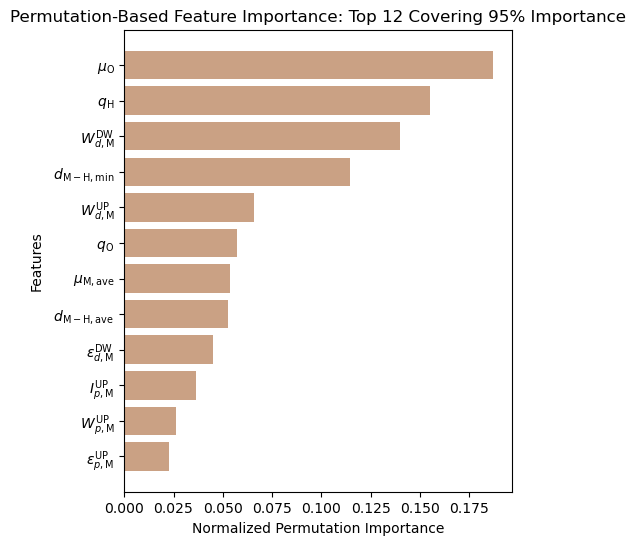

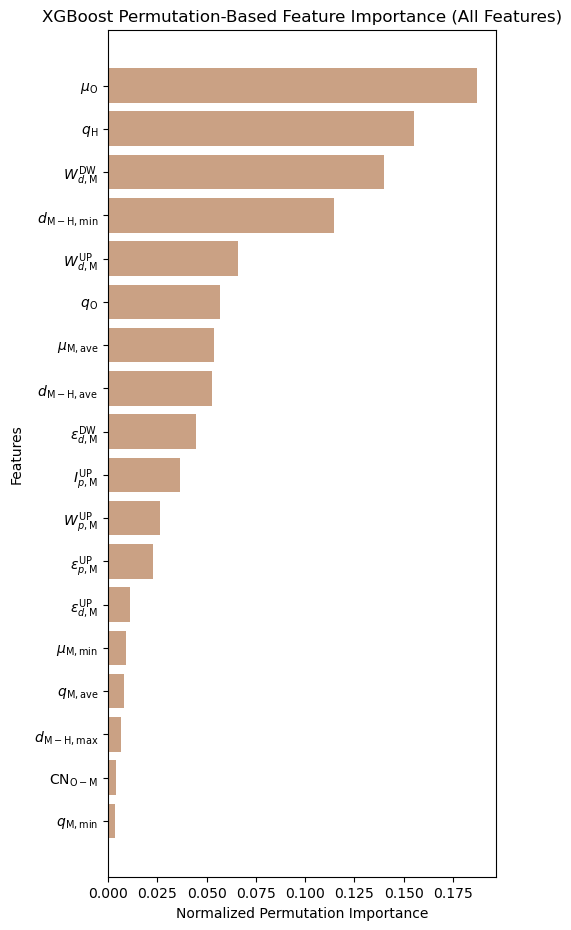

  Material  H_Energy  $\mu_{\mathrm{O}}$  $\ q_{\mathrm{H}}$  \
1  sample2 -0.329719               0.341            0.598094   
2  sample4 -0.225328               0.270            0.515022   
3  sample5 -0.591117               0.269            0.590602   
4  sample6 -0.356648               0.291            0.616530   
5  sample7 -0.503777               0.269            0.582824   

   $\ W^{\mathrm{DW}}_{d, \mathrm{M}}$  $\ d_{\mathrm{M-H, min}}$  \
1                            38.508306                   2.113117   
2                            31.018330                   1.849466   
3                            40.516705                   2.113724   
4                            25.035668                   2.188087   
5                            40.516705                   2.101904   

   $\ W^{\mathrm{UP}}_{d, \mathrm{M}}$  $\ q_{\mathrm{O}}$  \
1                           469.936405           -1.238573   
2                           315.050259           -1.245165   
3             

In [7]:
# 6. XGBoost Permutation-Based Feature Importance
# 6.1 Compute permutation importance on a VALIDATION/TEST set
# (Assuming you already have X_test, y_test from train_test_split)
result = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=50,          # you can change this (e.g., 20–50) for smoother stats
    scoring='r2',          # or 'neg_mean_squared_error', 'neg_mean_absolute_error'
    random_state=100,
    n_jobs=6
)

perm_importance_mean = result.importances_mean   # raw mean drop in score
perm_importance_std  = result.importances_std    # std over permutations

# 6.2 Clip negatives and normalize to sum = 1 (for cumulative 95% logic)
# (Negative means: shuffling sometimes "helps" by noise, not real importance)
importance_clipped = np.clip(perm_importance_mean, a_min=0, a_max=None)
total_importance = importance_clipped.sum()

if total_importance == 0:
    # Fallback: if everything is zero, treat all as equal
    xgb_importance = np.ones_like(importance_clipped) / len(importance_clipped)
else:
    xgb_importance = importance_clipped / total_importance  # now behaves like your old importance vector

# 6.3 Sort features in descending order of (normalized) permutation importance
sorted_indices = np.argsort(xgb_importance)[::-1]
sorted_importance = xgb_importance[sorted_indices]
sorted_features = X_filtered.columns[sorted_indices]

# 6.4 Compute cumulative importance
cumulative_importance = np.cumsum(sorted_importance)

# 6.5 Find the number of features covering 95% of total importance
num_important_features = np.argmax(cumulative_importance >= 0.95) + 1  # +1 to include the threshold feature

# Select only these top features
selected_features = sorted_features[:num_important_features]
selected_importance = sorted_importance[:num_important_features]

threshold_index = np.argmax(cumulative_importance >= 0.95)  # Keep top 95% importance
importance_threshold = sorted_importance[threshold_index]
print("Threshold of Permutation-Based Importance:", importance_threshold)
print(" ")

# 6.6 Plot the feature importance (Top 95%)
plt.figure(figsize=(5, 6))
plt.barh(selected_features[::-1], selected_importance[::-1], color="#CAA184")  # Reverse for better readability
plt.xlabel("Normalized Permutation Importance")
plt.ylabel("Features")
plt.title(f"Permutation-Based Feature Importance: Top {num_important_features} Covering 95% Importance")
plt.savefig("XGBoost Feature Importance (Top 95%)_H2O_2_Permutation.svg", dpi=600, bbox_inches='tight')
plt.show()

# 6.7 Plot all features (Permutation-based)
plt.figure(figsize=(5, 11))
plt.barh(X_filtered.columns[sorted_indices][::-1], xgb_importance[sorted_indices][::-1], color="#CAA184")
plt.xlabel("Normalized Permutation Importance")
plt.ylabel("Features")
plt.title("XGBoost Permutation-Based Feature Importance (All Features)")
plt.savefig("XGBoost Feature Importance_H2O_2_Permutation.svg", dpi=600, bbox_inches='tight')
plt.show()

# 6.8 Extract important features based on permutation importance
X_xgboost = X_filtered[selected_features]

# Combine materials name, target, and selected features
X_xgboost.insert(0, "H_Energy", y)       # Insert target as second column
X_xgboost.insert(0, "Material", materials)  # Insert materials name as first column
print(X_xgboost.iloc[1:6, :])
print(" ")

# Save new dataset with only important features
train_xgboost_path = "train.dat_host_xgboost_H2O_2_Permutation"
X_xgboost.to_csv(train_xgboost_path, sep="\t", index=False)
print(f"Saved {train_xgboost_path} with {len(selected_features)} features (Permutation threshold: {importance_threshold}).")
print(" ")

In [8]:
# 7. SHAP Analysis
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

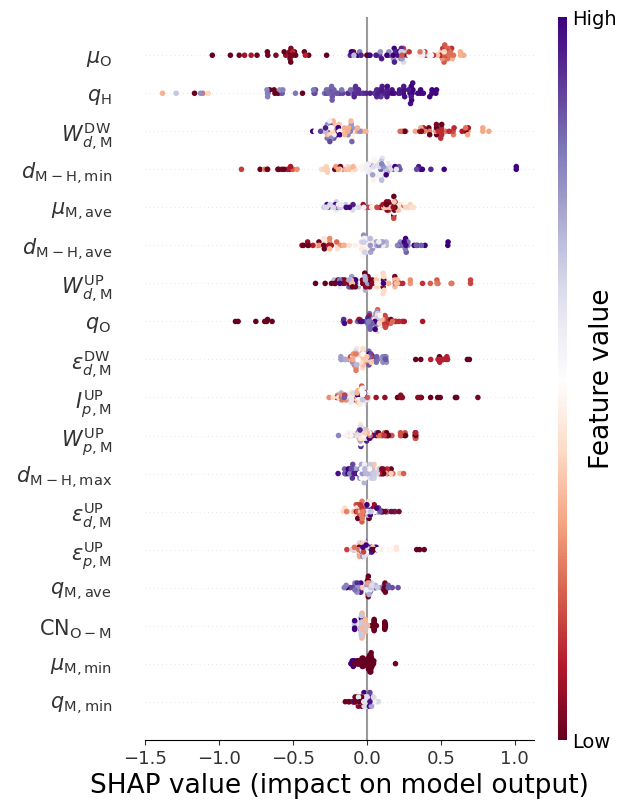

In [9]:
# 8. SHAP Summary Plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_filtered.columns, show=False, cmap=cmap_1_2)
ax = plt.gca()
ax.set_xlabel(ax.get_xlabel(), fontsize=19)
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
fig = plt.gcf()
fig.set_size_inches(6, 8)
# colorbar axis
cbar_ax = fig.axes[-1]
# Change colorbar label font size
cbar_ax.yaxis.label.set_size(19)
# Change colorbar tick label font size
cbar_ax.tick_params(labelsize=14)
cbar_ax.yaxis.labelpad = -20

plt.savefig("shap_summary_H2O_2.svg", dpi=600, bbox_inches="tight")
plt.show()

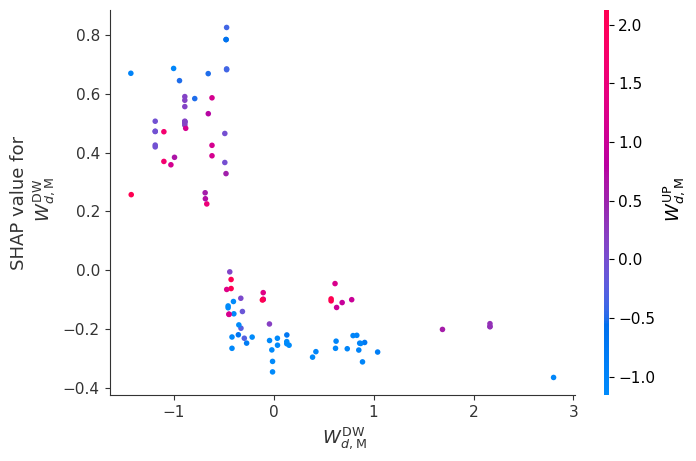

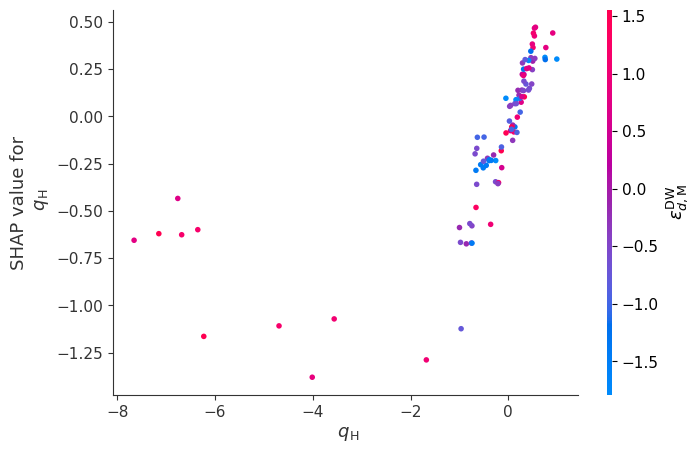

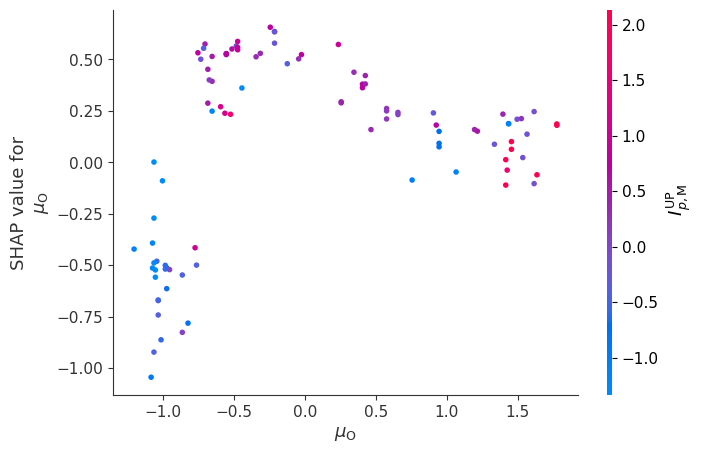

In [10]:
# 9. SHAP Dependence Plots (Top 3 most important features)
top_features = np.argsort(np.abs(shap_values.values).mean(axis=0))[-3:]

for feature_idx in top_features:
    feature_name = X_filtered.columns[feature_idx]
    shap.dependence_plot(feature_name, shap_values.values, X_test_scaled, feature_names=X_filtered.columns)


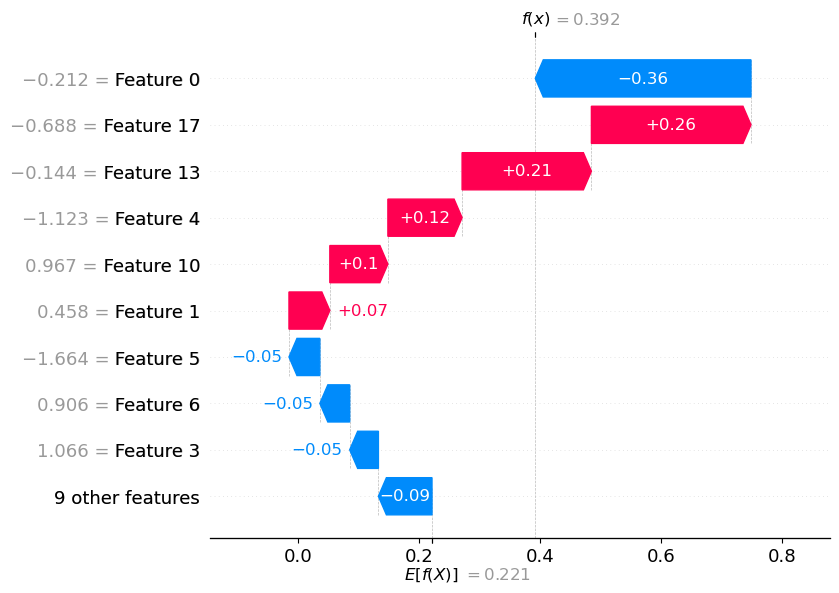

In [11]:
# 10. SHAP Waterfall Plot
sample_index = 0  # test sample
fig = plt.figure()
shap.plots.waterfall(shap_values[sample_index])
fig.savefig("shap_waterfall_H2O.svg", dpi=600, bbox_inches="tight")
plt.show()  # Now display the plot

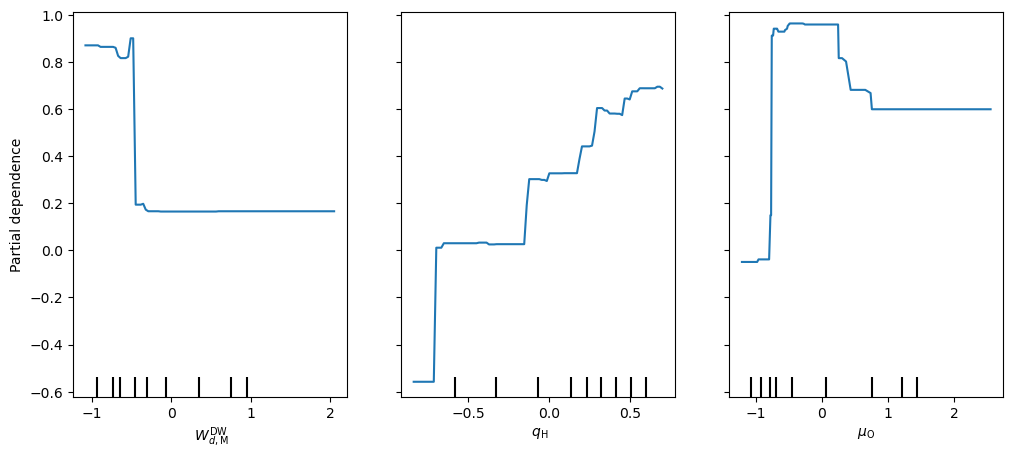

In [12]:
top_pdp_features = X_filtered.columns[np.argsort(xgb_importance)[-3:]]

fig, ax = plt.subplots(figsize=(12, 5))
pdp_display = PartialDependenceDisplay.from_estimator(best_model, X_train_scaled, features=top_pdp_features, ax=ax, feature_names=X_filtered.columns)
plt.show()